In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

np.random.seed(123)
plt.style.use('Solarize_Light2')

In [3]:
cdf_path = './../data/cdf_vs_sep.csv'
cdf_data = np.loadtxt(cdf_path, delimiter=',')

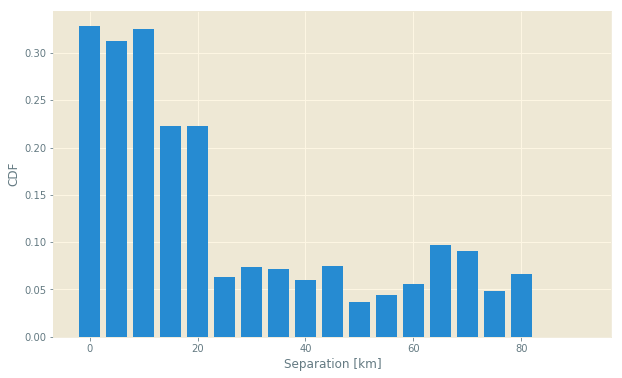

In [4]:
plt.figure(figsize=(10, 6))
plt.bar(cdf_data[:, 0], cdf_data[:, 1], width=0.8*(cdf_data[1, 0]-cdf_data[0, 0]));
plt.xlabel('Separation [km]'); plt.ylabel('CDF');

Make a Monte Carlo model for microburst scale size distribution

In [24]:
grid_size = 200
n_bursts = int(1E6)

Define spacecraft A's position and a family of spacecraft B's positions that will be used to calculate the CDF.

In [25]:
#sc_A = (0, 0)
#sc_B = [(0, di) for di in cdf_data[:, 0]]

Now generate n_bursts worth of microbursts within the grid, using a normally distributed scale size distribution.

In [40]:
burst_size = np.abs(np.random.normal(loc=10, scale=10, size=n_bursts))
burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)

Now plot a few example microbursts on the grid

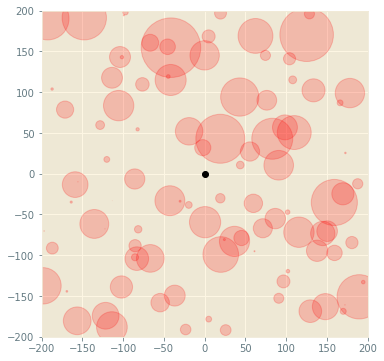

In [41]:
plot_n = 100
circles = plot_n*[None]
fig, ax = plt.subplots(figsize=(6, 6))

for c in range(plot_n):
    circles[c] = plt.Circle((burst_x[c], burst_y[c]), burst_size[c], color='r', alpha=0.2)
    ax.add_artist(circles[c])
plt.xlim(-grid_size, grid_size); plt.ylim(-grid_size, grid_size)
plt.scatter(*sc_A, c='k')
ax.set_aspect(1.0)

### Simple model 
one sc at the origin, and other sc on the y-axis at locations defined by the bins

In [43]:
bins = cdf_data[:, 0]

def dist(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

The function below is a mathematical way to determine if a particular circle touches a line segment. In this model, if the circle does not touch the y-axis, it will not be counted, so we can skip that iteration. http://mathworld.wolfram.com/Circle-LineIntersection.html

In [44]:
def circle_intersect(line_p, circle_p):
    """ 
    Returns true if a cicle defined by circle_p argument 
    defined as [center_x, center_y, radius] intersects a
    line defined as [x1, y1, x2, y2]. The line is assume 
    to be finite in length. 
    
    Reference: http://mathworld.wolfram.com/Circle-LineIntersection.html
    """
    line_p[0] -= circle_p[0]; line_p[2] -= circle_p[0]
    line_p[1] -= circle_p[1]; line_p[3] -= circle_p[1]
    dx = line_p[2] - line_p[0]
    dy = line_p[3] - line_p[1]
    dr = np.sqrt(dx**2 + dy**2)
    D = line_p[0]*line_p[3] - line_p[2]*line_p[1]
    if circle_p[2]**(2)*dr**2 - D**2 >= 0:
        return True
    else:
        return False

Now define a function that counts the number of single events seen by each spacecraft, and events seen togeather.

In [45]:
n_a = 0
n_b = np.zeros(len(bins))
n_coincident = np.zeros(len(bins))

for bx, by, br in zip(burst_x, burst_y, burst_size):
    # Skip if the circle did not intersect the y-axis.
    if not circle_intersect([0, 0, 0, 10], [bx, by, br]):
        continue
    # Check if that microburst was observed at the origin
    if dist(bx, by, 0, 0) <= br: 
        n_a +=1
    # Check if that microburst was observed by the other 
    # spacecraft 
    for i, scx in enumerate(bins):
        if dist(bx, by, 0, scx) <= br: 
            n_b[i] +=1
    # Check if that microburst was observed by both 
    # spacecraft
    for i, scx in enumerate(bins):
        if dist(bx, by, 0, scx) <= br and dist(bx, by, 0, 0) <= br: 
            n_coincident[i] +=1
cdf = n_coincident/(n_a + n_b)

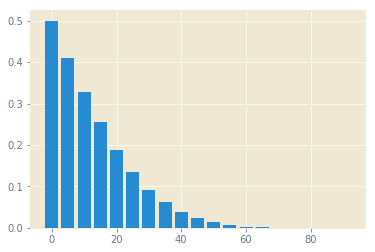

In [46]:
plt.bar(bins, cdf, width=0.8*(bins[1] - bins[0]));

### Wrap the model to be optimized

In [53]:
def model(_, s0, sigma):
    """ 
    Wrap the model to be optimized
    """
    # Run the simulation
    burst_size = np.abs(np.random.normal(loc=s0, scale=sigma, size=n_bursts))
    burst_x = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    burst_y = np.random.uniform(-grid_size, grid_size, size=n_bursts)
    # Tally the simulated events to make a cdf
    cdf = tally_events(burst_x, burst_y, burst_size, bins)
    # Apply a penatly (cost) function.
    cost = sum(np.power(cdf-cdf_data[:, 1], 2))/len(cdf)
    return cost
    
def tally_events(burst_x, burst_y, burst_size, bins):
    n_a = 0
    n_b = np.zeros(len(bins))
    n_coincident = np.zeros(len(bins))

    for bx, by, br in zip(burst_x, burst_y, burst_size):
        # Skip if the circle did not intersect the y-axis.
        if not circle_intersect([0, 0, 0, 10], [bx, by, br]):
            continue
        # Check if that microburst was observed at the origin
        if dist(bx, by, 0, 0) <= br: 
            n_a +=1
        # Check if that microburst was observed by the other 
        # spacecraft 
        for i, scx in enumerate(bins):
            if dist(bx, by, 0, scx) <= br: 
                n_b[i] +=1
        # Check if that microburst was observed by both 
        # spacecraft
        for i, scx in enumerate(bins):
            if dist(bx, by, 0, scx) <= br and dist(bx, by, 0, 0) <= br: 
                n_coincident[i] +=1
    cdf = n_coincident/(n_a + n_b)
    return cdf

### Find the Parameters that minimize the cost 

In [ ]:
p = scipy.optimize.minimize(model, range(5), args=(10, 20), method='Nelder-Mead')

In [ ]:
p